# Summary for March 2020

## Contents

1) Plots from a series of simulations done over a range of temperature with {'t': 1, 'alpha': 1.25, 'mu': 0, 'beta': 'Variable', 'J': 5, 'U': 1}

2) As a result of the worry about there appearing to be localised states at high temperatures, a phase diagram in U (interaction parameter) and temperature T.

In [1]:
%load_ext autoreload
%autoreload 2
%run ~/FKMC/notebooks/notebook_preamble.py
%matplotlib inline

In [13]:
from FKMC.general import index_histogram_array, sort_IPRs, smooth, shapes, get_nearby_index, normalise_IPR
from FKMC.import_funcs import get_data_structured

In [5]:
#this data has was preprocessed and saved in munich/Figures/Data_preparation_for_linear_T_plots.ipynb
#they both used get_data_structured so the IPR has not yet been normalised by DOS
#Beware that data gatherered using get_data_structured is normalised by DOS
with open('/data/users/tch14/pickled_data/Long_range_IPR_and_DOS_processed.pickle', 'rb') as file: 
    oLR = pickle.load(file)
    
#load in the data with correlation functions too
with open('/data/users/tch14/pickled_data/Long_range_linear_T_correlation_funcs.pickle', 'rb') as file: 
    oLR_corr = pickle.load(file)
    
print('Loaded data for Long Range IPR and DOS as a function of T')

Loaded data for Long Range IPR and DOS as a function of T


In [14]:
print("Computing IPR and DOS histograms and then smoothing them.")
o = oLR
o.I = [None for _ in o.Ns] 
o.E = [None for _ in o.Ns]
o.sI = [None for _ in o.Ns] 
o.sE = [None for _ in o.Ns]

for i, N in enumerate(o.Ns):
    
    #normalise IPR by dividing it by DOS
    o.E[i], o.I[i] = normalise_IPR(o.E_hist[i], o.IPR_hist[i])
    
    #smooth them
    o.sE[i] = smooth(o.E[i], scale = 64 / N)
    o.sI[i] = smooth(o.I[i], scale = 64 / N)
    
    o.sE[i] = o.sE[i] / N

Computing IPR and DOS histograms and then smoothing them.


## Display the hamiltonian and simulation parameters for Long range data:
- Long ranged: 1 < alpha < 2 (also alpha < 1.5 so it has classical exponents rather than ones that change as a function of alpha)
- uses 10 millions MCMC steps but only saves every 1000th. This trades off extra computation time on the cluster to get samples that are less correlated, hence fewer samples need to be stored to get a given statistical error and less computation needs to be done to take means and make plots.

In [11]:
print(f"Keys available in long range data: {oLR.keys()}")

print("Hamiltionian params for the Long Range data:")
oLR.parameters['beta'] = "Variable"
print(", ".join(f"{k} = {v}" for k,v in oLR.parameters.items()))
print('\n')

print("Simulation params for the Long Range data:")
print(oLR.MCMC_params)

Keys available in long range data: dict_keys(['Ns', 'parameters', 'MCMC_params', 'desc', 'structure_names', 'structure_dims', 'hints', 'Ts', 'E_bins', 'E_hist', 'IPR_hist', 'I', 'E', 'sI', 'sE'])
Hamiltionian params for the Long Range data:
t = 1, alpha = 1.25, mu = 0, beta = Variable, J = 5, U = 1, normalise = True, J_matrix = ...


Simulation params for the Long Range data:
{'state': '...', 'N_steps': 100000, 'N_burn_in': 1000, 'thin': 1000, 'logger': <FKMC.montecarlo.Eigenspectrum_IPR_all object at 0x7f67bdc7ba90>, 'proposal': <function p_multi_site_uniform_reflect at 0x7f67be63db70>, 'accept_function': <function perturbation_accept at 0x7f67be63dea0>, 'warnings': True}


## Looking at the DOS and IPR at different temperatures
Below is the animation that I showed in the talk. It caused concern because it looks like the mid-gap states are becoming extended at high temperatures.

Top Left: The density of states DOS(energy) with energy along the x axis and temperature along the y. The gap closing is visble at high temperaures.

Bottom Left: The IPR with the same axes, the phase transiton is visible at around T  = 1, and something else seems to happen around T = 2.

The next four figures are at a fixed temperature where the black line is on the left two figures.

The correlation functions are <s_i s_(i + d)> averaged over i where s_i takes on values +1/2 and -1/2 and it s_i is staggered such that the CDW states yields either all +1/2 or all -1/2. Hence 

$$c(0) = <s_i  s_i> = 1/4$$

In [107]:
%%capture
from matplotlib.animation import FuncAnimation
from IPython.display import HTML, display

from matplotlib.cm import get_cmap
cmap = get_cmap('Set1')

f, axes = plt.subplots(2,3, figsize = (15,10), gridspec_kw = dict(wspace = 0.25, hspace = 0.25))

i = -1

axes[0,0].set(xlim = (-5,5), ylabel = 'DOS\nT')
axes[1,0].set(xlim = (-5,5), ylabel = 'IPR\nT', xlabel = '$\omega$')

axes[0,1].set(xlim = (-5,5), ylim = (0,  10), ylabel = 'DOS')
axes[1,1].set(xlim = (-5,5), ylim = (0, 0.2), ylabel = 'IPR', xlabel = '$\omega$')

axes[0,2].set(xlim = (0,70), ylim = (1e-3, 1), ylabel = 'Spin-Spin Correlation')
axes[1,2].set(xlim = (1,70), ylim = (1e-3, 1), ylabel = 'Spin-Spin Correlation', xlabel = 'Site')

legend = None

def init():
    global h1, h2, E_lines, IPR_lines, C_lines, C_log_lines, legend
    #text = ax.text(0,1.05, f' ', fontsize = 15, transform=ax.transAxes)
    i = -1
    norm = colors.Normalize(vmin = 0)
    cs = axes[0, 0].pcolormesh(o.E_bins, o.Ts, o.sE[i], cmap='RdBu_r', norm = norm)

    norm = colors.Normalize(vmin = 0)
    cs = axes[1, 0].pcolormesh(o.E_bins, o.Ts, o.sI[i], cmap='RdBu_r', norm = norm)

    T_select = 0
    T = o.Ts[T_select]

    h1, = axes[1,0].plot((-6, 6), (T, T), 'k--')
    h2, = axes[0,0].plot((-6, 6), (T, T), 'k--')

    IPR_lines = [None for _ in o.Ns]
    E_lines = [None for _ in o.Ns]
    C_lines = [None for _ in o.Ns]
    C_log_lines = [None for _ in o.Ns]
    
    for i, N in enumerate(o.Ns):
        if N > 16:
            color = cmap((i - 2)/3)
            
            E_lines[i], = axes[0, 1].plot(o.E_bins[1:], o.sE[i][T_select, :] * np.NaN, color = color)
            IPR_lines[i], = axes[1, 1].plot(o.E_bins[1: ], o.sI[i][T_select, :] * np.NaN, color = color)

            corr = oLR_corr.C[i][T_select].mean(axis = 0)[:N//2]
            C_lines[i], = axes[0, 2].plot(np.arange(N//2), corr * np.NaN, label = f'N = {N}', color = color) 
            C_log_lines[i], = axes[1, 2].loglog(np.arange(N//2), corr * np.NaN, color = color) 
        
        
    
    if legend == None: legend = axes[0, 2].legend(loc = 'upper center')
    return np.concatenate([E_lines, IPR_lines, C_lines, C_log_lines, [h1, h2]])

def update(frame):
    global h1, h2, E_lines, IPR_lines, C_lines, C_log_lines

    T_select = frame
    T = o.Ts[T_select]

    h1.set_data((-6, 6), (T,T))
    h2.set_data((-6, 6), (T,T))

    for i, N in enumerate(o.Ns):
        if N > 16:
            E_lines[i].set_data( o.E_bins[1:], o.sE[i][T_select, :])
            IPR_lines[i].set_data(o.E_bins[1: ], o.sI[i][T_select, :])


            corr = oLR_corr.C[i][T_select].mean(axis = 0)[:N//2]
            C_lines[i].set_data(np.arange(N//2), corr) 
            C_log_lines[i].set_data(np.arange(N//2), corr) 
    
    return np.concatenate([E_lines, IPR_lines, C_lines, C_log_lines, [h1, h2]])

frames = range(0,200,1)
interval = 20000 /len(frames)

ani = FuncAnimation(f, update, 
                    frames=frames,
                    init_func=init, blit=False,
                    repeat_delay = 1000,
                    interval = interval,
        )
        
#ani.save('LR_IPR_sweep_corr.mp4', dpi = 300)

In [108]:
HTML(ani.to_html5_video())

In [81]:
def plot_DOR_IPR_correlation(target_T):
    f, axes = plt.subplots(2,3, figsize = (15,10))
    i = -1 #determines which system size to use, -1 uses the largest which is 128

    norm = colors.Normalize(vmin = 0)
    cs = axes[0, 0].pcolormesh(o.E_bins, o.Ts, o.sE[i], cmap='RdBu_r', norm = norm)
    axes[0, 0].set(xlabel = '$\omega$', ylabel = 'T (colour is DOS)')

    norm = colors.Normalize(vmin = 0)
    cs = axes[1, 0].pcolormesh(o.E_bins, o.Ts, o.sI[i], cmap='RdBu_r', norm = norm)
    axes[1, 0].set(xlabel = '$\omega$', ylabel = 'T (colour is IPR)')

    axes[0, 1].set(xlabel = '$\omega$', ylabel = 'DOS')
    axes[1, 1].set(xlabel = '$\omega$', ylabel = 'IPR')

    axes[0, 2].set(xlabel = 'l', ylabel = 'C(l)')
    axes[1, 2].set(xlabel = 'l', ylabel = 'C(l)')

    T, T_select = get_nearby_index(o.Ts, target_T)
    #print(f'The black line is drawn at T = {T:.2f}')

    for i, N in enumerate(o.Ns):
        if N < 32: continue

        axes[0, 1].plot(o.E_bins[1:], o.sE[i][T_select, :], label = f'N = {N}')
        axes[1, 1].plot(o.E_bins[1: ], o.sI[i][T_select, :])

        #C[d] is <s_i s_i+d>
        corr = oLR_corr.C[i][T_select].mean(axis = 0)[:N//2]
        axes[0, 2].plot(corr)    
        axes[1, 2].loglog(corr)

    f.suptitle(f"IPR and Correlation functions at T = {T:.2f}")

    axes[0, 1].legend()
    axes[1,0].hlines(T, -6, 6)
    axes[0,0].hlines(T, -6, 6);

## CDW Phase / Low temperature T = 0.71
DOS: the two bands looks about right.

IPR: The middle of the bands scales away with system size, suggesting delocalised/extended states, the edges of the bands don't seems to scale away, suggesting there are localised states there along with a mobility edge. Looks right.

Top Right: Correlation function, linear plot.
Bottom Right: The same but plotted on a log-log plot. 
 
I'm not sure how to interpret the correllation functions here, it looks like either the correlation length is much larger than the system size at these temperatures or they're power law with a small exponent. 

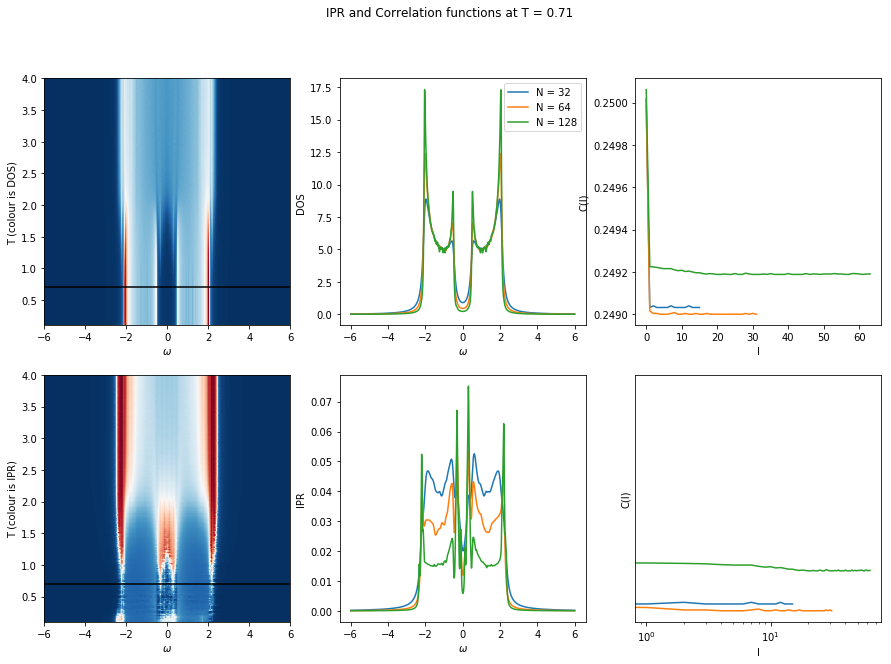

In [82]:
plot_DOR_IPR_correlation(target_T = 0.7)

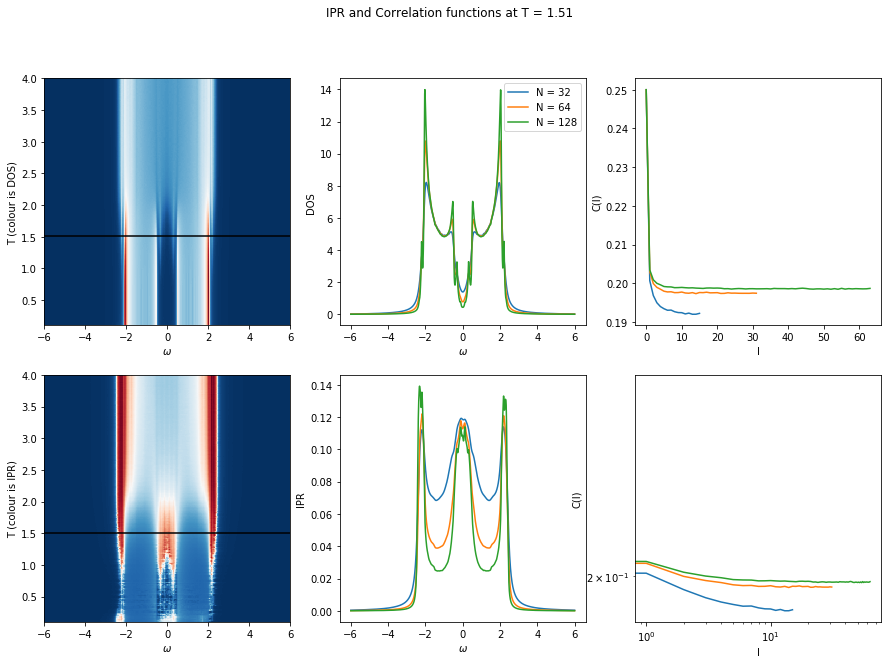

In [8]:
plot_DOR_IPR_correlation(target_T = 1.5)

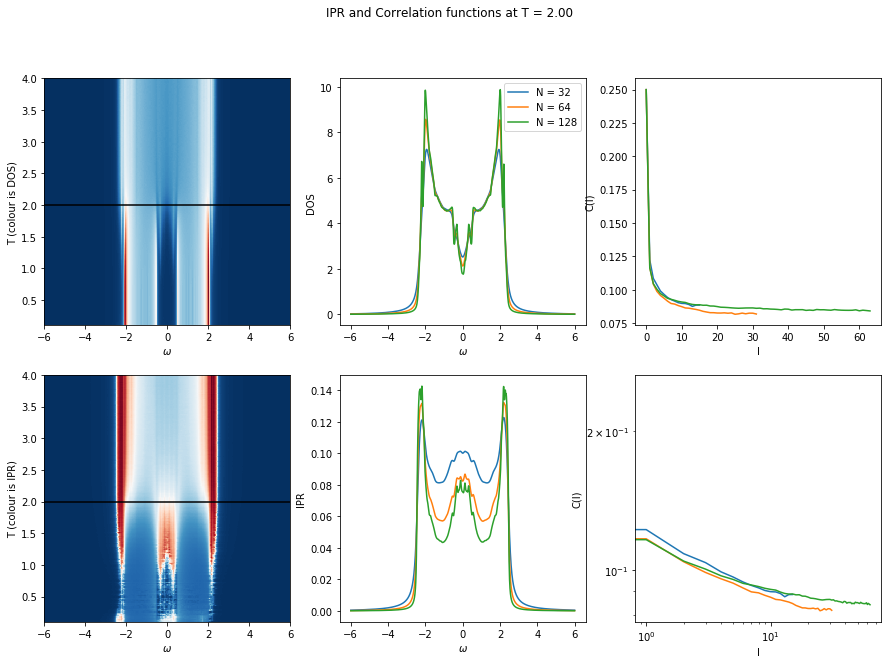

In [86]:
plot_DOR_IPR_correlation(target_T = 2)

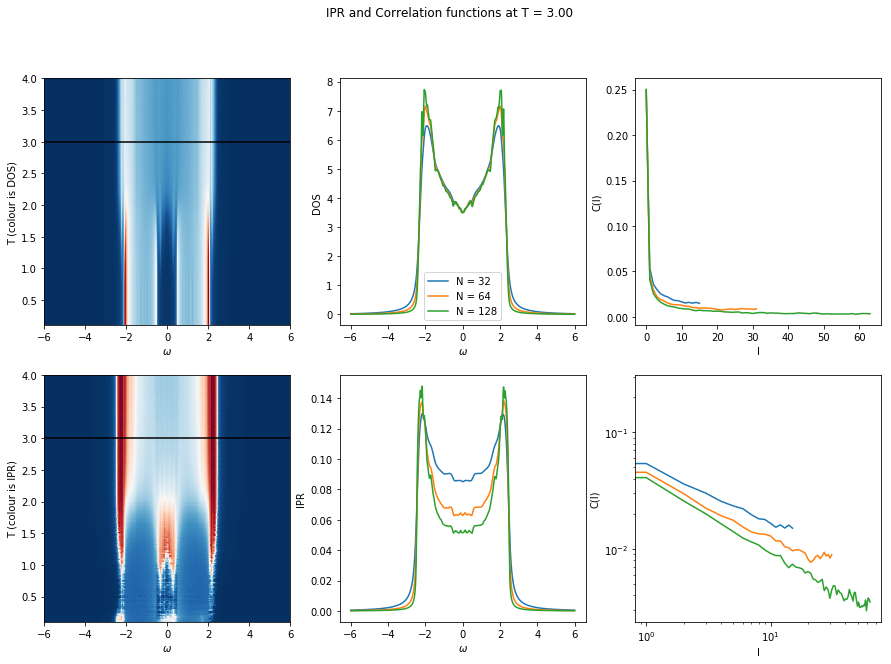

In [88]:
plot_DOR_IPR_correlation(target_T = 3)

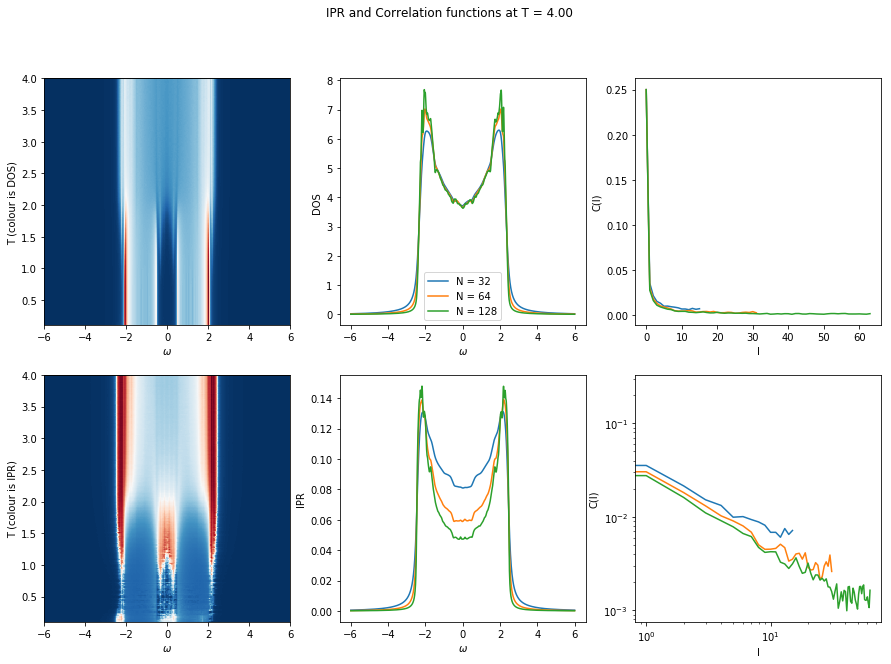

In [90]:
plot_DOR_IPR_correlation(target_T = 4)

# Varying U to see how that influnces the above phenomena

In [91]:
with open('/data/users/tch14/pickled_data/TU_phase_data.pickle', 'rb') as file: 
    TU_phase_obs = pickle.load(file)  

In [111]:
%%capture
from matplotlib.animation import FuncAnimation
from IPython.display import HTML, display

def lerp(start, end, lerp): return start * (1 - lerp) + lerp * end
T_bot = 0.5
T_top = 4
U_left = 1
U_right = 8

##how wide to make the central energy interval
e = 0.3

##where to make cuts for the scaling lines
energy_cuts = [0, 2, 3, 4]
cut_colors = 'rgbky'
energy_cuts_exact, energy_cuts_i = np.array([get_nearby_index(TU_phase_obs.E_bins, E) for E in energy_cuts]).T
energy_cuts_i = energy_cuts_i.astype(int)

def move_shape(i):
    if i < 0.25:
        j = i / 0.25
        T = lerp(T_bot, T_top, j)
        U = U_left
        return T, U
    if i < 0.5:
        j = (i-0.25) / 0.25
        T = T_top
        U = lerp(U_left, U_right, j)
        return T, U
    if i < 0.75:
        j = (i-0.5) / 0.25
        T = lerp(T_top, T_bot, j)
        U = U_right
        return T, U
    else:
        j = (i-0.75) / 0.25
        T = T_bot
        U = lerp(U_right, U_left, j)
        return T, U
    
f, axes = plt.subplots(3,2, figsize = (10,15), gridspec_kw = dict(wspace = 0.25, hspace = 0.25))
axes = axes.flatten()
axes[[0,1,2,3,4,5]] = axes[:]
    
###   plot the phase diagrams
binder = 0
norm = mpl.colors.Normalize(vmin=0, vmax=1)
#TU_data.hints.Mf_moments == ('Ns', 'repeats', 'Us', 'Ts', 'moment', 'MCstep')
M2 = TU_phase_obs.Mf_moments[-1, :, :, :, 2].mean(axis = 0).T
M4 = TU_phase_obs.Mf_moments[-1, :, :, :, 4].mean(axis = 0).T
Y = M2**2 / M4 if binder else M2

pcol = axes[0].pcolormesh(TU_phase_obs.Us, TU_phase_obs.Ts, Y, cmap="RdBu_r", norm = norm, linewidth=0, rasterized = True)

E_bins = TU_phase_obs.E_bins 
axes[2].vlines((-e, e), ymin = 0, ymax = 900)
axes[3].vlines((-e, e), ymin = 0, ymax = 800)

axes[0].set(title = 'Order Parameter')
axes[1].set(title = '# of states near E = 0')
axes[2].set(xlim = (-10, 10),     title = 'DOS')
axes[3].set(xlim = (-2*e, 2*e), title = 'Zoom on DOS around E = 0', ylim = (0, 500))
axes[4].set(xlim = (-10, 10),     title = 'IPR', ylim = (0, 0.5))


gap_indices = (-e < E_bins[:-1]) & (E_bins[:-1] < e)
gap_state_count = TU_phase_obs.DOS[-1, :, :, :, :].mean(axis=0)[:, :, gap_indices].sum(axis = -1)

pcol = axes[1].pcolormesh(TU_phase_obs.Us, TU_phase_obs.Ts, gap_state_count, cmap="RdBu_r", linewidth=0, rasterized = True)

#axes[0,0].set(xlim = (-5,5), ylabel = 'DOS\nT')
#axes[1,0].set(ylabel = 'IPR\nT', xlabel = '$\omega$')

#axes[0,1].set(ylabel = 'DOS')
#axes[1,1].set(ylabel = 'IPR', xlabel = '$\omega$')

legends = [None, None]
points = [None, None]
IPR_vlines = [None for _ in energy_cuts_exact]
E_lines = [None for _ in TU_phase_obs.Ns]
E_lines2 = [None for _ in TU_phase_obs.Ns]
IPR_lines = [None for _ in TU_phase_obs.Ns]
E_cut_lines = [None for _ in energy_cuts]

#plot all the stuff that needs to change and save references to them
def init():
    global legends
    #text = ax.text(0,1.05, f' ', fontsize = 15, transform=ax.transAxes)    
    
    T, T_i = get_nearby_index(TU_phase_obs.Ts, 0)
    U, U_i = get_nearby_index(TU_phase_obs.Us, 0)
    
    points[0], = axes[0].plot([U,], [T], color = 'k', marker = 'o')
    points[1], = axes[1].plot([U,], [T], color = 'k', marker = 'o')
    
    for i, E_i, E, colour in zip(count(), energy_cuts_i, energy_cuts_exact, cut_colors):
        IPR_cut = TU_phase_obs.IPR[:, :, U_i, T_i, E_i].mean(axis = 1)
        
        E_cut_lines[i], = axes[5].plot(TU_phase_obs.Ns, np.NaN*IPR_cut, color = colour, label = f'E = {E}', marker = 'o', linestyle = 'None')
        IPR_vlines[i], = axes[4].plot([E,E], [0,900], color = colour, linestyle= 'dashed')


    #IPR_lines = []
    #E_lines = []
    #for i, N in enumerate(o.Ns):
        #E_line, = axes[0, 1].plot(o.E_bins[1:], o.sE[i][T_select, :], label = f'N = {N}')
        #IPR_line, = axes[1, 1].plot(o.E_bins[1: ], o.sI[i][T_select, :])
        #E_lines.append(E_line)
        #IPR_lines.append(IPR_line)
        
    for i, N in zip(count(), TU_phase_obs.Ns):
        if N < 16: continue
        IPR = TU_phase_obs.IPR[i, :, U_i, T_i, :].mean(axis = 0)
        DOS = TU_phase_obs.DOS[i, :, U_i, T_i, :].mean(axis = 0)

        #smooth by a value dependant on the size
        IPR = smooth(IPR, scale = 32/N, axis = -1)
        DOS = smooth(DOS, scale = 32/N, axis = -1)

        E_lines[i], = axes[2].plot(E_bins[:-1], np.NaN*DOS, label = f'N = {N}')
        E_lines2[i], = axes[3].plot(E_bins[:-1], np.NaN*DOS, label = f'N = {N}')
        IPR_lines[i], = axes[4].plot(E_bins[:-1], np.NaN*IPR)
        

    
    if legends[0] == None: legends[0] = axes[2].legend(loc = 'upper left')
    if legends[1] == None: legends[1] = axes[5].legend()
    return np.concatenate([points, E_lines, IPR_lines, IPR_vlines, E_cut_lines, legends])
    
def update(frame):
    T, U =  move_shape(frame)
    
    T, T_i = get_nearby_index(TU_phase_obs.Ts, T)
    U, U_i = get_nearby_index(TU_phase_obs.Us, U)

    for p in points: p.set_data((U, ), (T, ))

    for i, N in zip(count(), TU_phase_obs.Ns):
        if N < 16: continue
        IPR = TU_phase_obs.IPR[i, :, U_i, T_i, :].mean(axis = 0)
        DOS = TU_phase_obs.DOS[i, :, U_i, T_i, :].mean(axis = 0)
        
        o.E[i] = np.where(o.E_hist[i] > 0, o.E_hist[i], 1)
        o.I[i] = np.where(o.E_hist[i] > 0, o.IPR_hist[i]/o.E[i], 0)

        o.sI[i] = smooth(o.I[i], scale = 64 / N, axis = -1)
        o.sE[i] = smooth(o.E_hist[i], scale = 64/N, axis = -1) / N #normalise DOS AFTER using it to normalise IPR
        
        #smooth by a value dependant on the size
        sIPR = smooth(IPR, scale = 32/N, axis = -1)
        sDOS = smooth(DOS, scale = 32/N, axis = -1)

        E_lines[i].set_data(E_bins[:-1], sDOS)
        E_lines2[i].set_data(E_bins[:-1], DOS) #not smoothed!
        
        IPR_lines[i].set_data(E_bins[:-1], sIPR)
    
    for i, E_i, E, colour in zip(count(), energy_cuts_i, energy_cuts_exact, cut_colors):
        IPR_cut = TU_phase_obs.IPR[:, :, U_i, T_i, E_i].mean(axis = 1)
        
        E_cut_lines[i].set_data(TU_phase_obs.Ns, IPR_cut)
        #IPR_vlines[i].set_data([E,E], [0,900])
    
    return np.concatenate([points, E_lines, E_lines2, IPR_lines, E_cut_lines])
    
frames = np.linspace(0,1,240)

interval = 40000 /len(frames)

aniTU = FuncAnimation(f, update, 
                    frames=frames,
                    init_func=init, 
                    blit=False,
                    repeat_delay = 1000,
                    interval = interval,
        )
        


In [112]:
HTML(aniTU.to_html5_video())